In [1]:
import pandas as pd
import numpy as np
import os
import random
import itertools
from pathlib import Path

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from seaborn import heatmap
from sklearn.metrics import silhouette_score

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [3]:
# Load final exam and assignment data
data = pd.DataFrame(columns=['SubjectID', 'Assignment', 'CodeStateID'])
grades = {}
scores = {}
total_non_compile = 0
data_dir = Path.cwd() / 'data'
for directory in [data_dir / 'F19_All' / 'Train', data_dir / 'S19_All']:
  grade_data = pd.read_csv(directory / 'Data' / 'LinkTables' / 'Subject.csv')
  for row in grade_data.itertuples():
    grades[row.SubjectID] = row._2 if directory.name == 'S19_All' else row._2 / 100
  main = pd.read_csv(directory / 'Data' / 'MainTable.csv')
  total_non_compile += len(main['CodeStateID'].unique())
  for row in main[main['EventType'] == 'Run.Program'].itertuples():
    scores[row.CodeStateID] = row.Score
  main['Assignment'] = [f'{int(x[0])}-{int(x[1])}' for x in list(zip(main['AssignmentID'], main['ProblemID']))]
  data = pd.concat([data, main[['SubjectID', 'Assignment', 'CodeStateID']]], ignore_index=True)

data['Score'] = [scores[x] for x in data['CodeStateID']]
data['ExamGrade'] = [grades[x] if x in grades else 0 for x in data['SubjectID']]
data = data[data['Score'] == 1]
data.head()

,SubjectID,Assignment,CodeStateID,Score,ExamGrade
0,014604ba54339d4b1266cf78e125053a5ac11dd861ef3cc0b4ed777ed0e2af0a,439-1,79c9e2da9bc703116d8768297056db22866c43d583e529d73bf25235f1ca6b16,1.0,0.97
1,014604ba54339d4b1266cf78e125053a5ac11dd861ef3cc0b4ed777ed0e2af0a,439-1,79c9e2da9bc703116d8768297056db22866c43d583e529d73bf25235f1ca6b16,1.0,0.97
2,014604ba54339d4b1266cf78e125053a5ac11dd861ef3cc0b4ed777ed0e2af0a,439-3,0e91ae5696da0d6a724380360147b8699a25c14ff4622713875f92127b52737b,1.0,0.97
3,014604ba54339d4b1266cf78e125053a5ac11dd861ef3cc0b4ed777ed0e2af0a,439-3,0e91ae5696da0d6a724380360147b8699a25c14ff4622713875f92127b52737b,1.0,0.97
4,014604ba54339d4b1266cf78e125053a5ac11dd861ef3cc0b4ed777ed0e2af0a,439-5,1b38c7b1c7ebca281bbbc270d1b896484de663045c715fd4ec54ab6b36859106,1.0,0.97


In [4]:
random.seed(1)
code_ids = data['CodeStateID']
assignments = data['Assignment']
assign_c = {}
unique_assignments = data['Assignment'].unique()
for assign in unique_assignments:
  assign_c[assign] = (random.random(), random.random(), random.random())
assign_lookup = {}
for c_id, assign in zip(code_ids, assignments):
  assign_lookup[c_id] = assign

In [5]:
canonicalization_strats = ['full', 'part', 'none', 'orig']
canonicalized_vectors = ['deepwalk', 'node2vec']

In [6]:
embedding_vectors = [
  ('code2vec', 384),
  ('tf_idf', 50)
]

for strat, vec_file in itertools.product(canonicalization_strats, canonicalized_vectors):
  embedding_vectors.append(
    (
      f'{strat}Canonicalization{vec_file}',
      50
    )
  )

In [7]:
vector_dir = Path.cwd() / 'data' / 'Vectors'
vector_files = [(vector_dir / f'{f}.csv', s) for f, s in embedding_vectors]

In [8]:
# def assign_colors(frame, vector_size):
#   frame = frame[[x in assign_lookup for x in frame['CodeStateID']]]
#   vectors = frame.iloc[:,0:vector_size]
#   pca = PCA(random_state=1, n_components=2)
#   pca.fit(vectors)
#   vectors = pca.transform(vectors)
#   plt.scatter(vectors[:,0], vectors[:,1], marker='.', s=1, c=[assign_c[assign_lookup[x]] for x in frame['CodeStateID']])
#   plt.show()
#   sill_scores = {'data/Vectors/deepwalk.csv': -0.25236, 'data/Vectors/code2vec.csv': -0.16918, 'data/Vectors/node2vec.csv': -0.25136, 'data/Vectors/tf_idf.csv': 0}
#   print(f'Silhouette Score: {sill_scores[file]}')

In [9]:
def get_distance_summary(dist_groups : dict):
    dist_df = pd.DataFrame.from_dict(dist_groups)
    dist_df = dist_df.T
    dist_df = (dist_df - dist_df.min()) / (dist_df.max() - dist_df.min())
    dist_df = dist_df.T
    return dist_df.describe().T.sort_index()

how_similar = {
    (1, 2): 'similar',
    (1, 3): 'dissimilar',
    (1, 4): 'dissimilar',
    (2, 3): 'dissimilar',
    (2, 4): 'dissimilar',
    (3, 4): 'similar'
}

ex_map = {
    '487-20': 1,
    '439-236': 2,
    '439-232': 3,
    '439-234': 4
}

def get_dist_group_name(p1, p2):
    p1 = ex_map[p1]
    p2 = ex_map[p2]
    if p1 == p2:
        return f'same_{p1}'
    s1, s2 = sorted([p1, p2])
    return f'{how_similar[(s1, s2)]}_{p1}-{p2}'

def add_to_dist_groups(groups, dist, p1, p2):
    group_name = get_dist_group_name(p1, p2)
    if group_name not in groups:
        groups[group_name] = []
    groups[group_name].append(dist)

In [10]:
def heat_map(frame, vector_size, output):
  PROBLEMS = ['439-236', '487-20', '439-232', '439-234']
  random.seed(1)
  vector_map = {}
  vectors = np.array(frame.iloc[:,0:vector_size])
  c_ids = frame['CodeStateID']
  for v, c in zip(vectors, c_ids):
    vector_map[c] = v
  NUM_VECTORS = 100
  filt = data[[x in vector_map for x in data['CodeStateID']]]
  chosen_vectors = []
  chosen_ids = []
  for problem in PROBLEMS:
    filt2 = filt[filt['Assignment'] == problem].reset_index()
    chosen_ids += random.sample(list(filt2['CodeStateID']), 10)
  chosen_vectors = [vector_map[x] for x in chosen_ids]
  distances = np.zeros((len(chosen_vectors), len(chosen_vectors)))
  dist_groups = {}
  problems = [[p]*10 for p in PROBLEMS]
  for i, p1 in zip(range(len(chosen_vectors)), itertools.chain.from_iterable(problems)):
    for j, p2 in zip(range(len(chosen_vectors)), itertools.chain.from_iterable(problems)):
      dist = np.linalg.norm(chosen_vectors[i] - chosen_vectors[j])
      add_to_dist_groups(dist_groups, dist, p1, p2)
      distances[i][j] = dist
      distances[j][i] = dist
  print(get_distance_summary(dist_groups))
  heatmap(distances)
  plt.savefig(output)
  plt.clf()
#   print(chosen_ids)

Ideal heat map


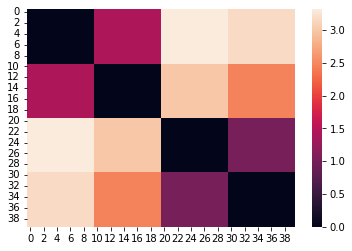

In [11]:
print("Ideal heat map")
vectors = []
distances = np.zeros((40, 40))
for i in range(10):
  vectors.append(np.array([0, 1, 1]))
for i in range(10):
  vectors.append(np.array([1, 2, 1]))
for i in range(10):
  vectors.append(np.array([3, 0, 0]))
for i in range(10):
  vectors.append(np.array([3, 1, 0]))
for i in range(len(vectors)):
  for j in range(i, len(vectors)):
    dist = np.linalg.norm(vectors[i] - vectors[j])
    distances[i][j] = dist
    distances[j][i] = dist
heatmap(distances)
plt.show()

In [12]:
# assign_colors('data/Vectors/tf_idf.csv', 50)
# assign_colors('data/Vectors/code2vec.csv', 384)
# assign_colors('data/Vectors/deepwalk.csv', 50)
# assign_colors('data/Vectors/node2vec.csv', 50)

In [13]:
heatmap_dir = data_dir / 'Images' / 'heatmaps'
heatmap_dir.mkdir(parents=True, exist_ok=True)
for file, size in vector_files:
    print()
    print(file.stem)
    heat_map(pd.read_csv(file), size, heatmap_dir / f'{file.stem}.png')


code2vec
                count      mean       std       min       25%       50%       75%       max
same_2          100.0  0.086237  0.074617  0.000000  0.007985  0.088717  0.144851  0.278817
similar_2-1     100.0  0.614867  0.109974  0.341618  0.531919  0.632314  0.702140  0.806783
dissimilar_2-3  100.0  0.909770  0.061258  0.759085  0.869128  0.910980  0.956155  1.000000
dissimilar_2-4  100.0  0.901364  0.050679  0.794648  0.864032  0.897367  0.931879  1.000000
similar_1-2     100.0  0.614867  0.109974  0.341618  0.531919  0.632314  0.702140  0.806783
same_1          100.0  0.217939  0.137123  0.000000  0.117459  0.222085  0.324113  0.464224
dissimilar_1-3  100.0  0.880234  0.085547  0.602185  0.832658  0.903266  0.943112  0.997453
dissimilar_1-4  100.0  0.920379  0.088515  0.706778  0.844130  0.957955  1.000000  1.000000
dissimilar_3-2  100.0  0.909770  0.061258  0.759085  0.869128  0.910980  0.956155  1.000000
dissimilar_3-1  100.0  0.880234  0.085547  0.602185  0.832658  0.90326

<Figure size 432x288 with 0 Axes>